In [2]:
from sionna.channel import AWGN
from sionna.utils import BinarySource, ebnodb2no
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils import sim_ber
import sionna as sn
import matplotlib as mpl
import utils
from utils.my_utils import ebno_db_setup, load_weights, save_weights, bit2onehot, Normalize, Q_func

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv1D, Activation
import sys
sys.path.append('..')
from config import WEIGHTS_PATH

In [ ]:
#Intialized Parameters
n = 6000
num_bits_per_symbol = 4
M = 2**num_bits_per_symbol
coderate = 1.0
n_channel = 1
num_symbols_per_codeword = n//num_bits_per_symbol

#Training parameters
weights_path = WEIGHTS_PATH
training_batch_size = tf.constant(128, tf.int32)

d:\2024_2\ATC_Conference\Neural-Network-based-Information-Theoretic-Transceivers\weights


In [ ]:
No = -114       
B = 10**6       
R = 1           

EBNO_MIN = ebno_db_setup(-64, No, B, R)
EBNO_MAX = ebno_db_setup(-34, No, B, R)
EBNO_TRAIN = ebno_db_setup(-42, No, B, R)
print(f"EBNO_MIN: {EBNO_MIN:.2f}")
print(f"EBNO_MAX: {EBNO_MAX:.2f}")
print(f"EBNO_TRAIN: {EBNO_TRAIN:.2f}")

EBNO_MIN: -10.00
EBNO_MAX: 20.00
EBNO_TRAIN: 12.00


### AE-CNN

In [ ]:
class E2E_AE_CNN(Model):
    def __init__(self, training):
        super().__init__()
        self._training = training
        self._binary_source = BinarySource()

        # Transmitter
        self.conv1 = Conv1D(32, kernel_size=3, strides=1, padding='same')
        self.conv2 = Conv1D(16, kernel_size=3, strides=1, padding='same')
        self.dense_tx = Dense(2*n_channel)  # Outputs real and imaginary parts

        # Channel
        self._channel = AWGN()

        # Receiver
        self.conv3 = Conv1D(16, kernel_size=3, strides=1, padding='same')
        self.conv4 = Conv1D(32, kernel_size=3, strides=1, padding='same')
        self.dense_rx = Dense(2**num_bits_per_symbol, activation= 'softmax')

        if self._training:
            self._ce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function()
    def call(self, batch_size, ebno_db):
        batch_size = tf.cast(batch_size, dtype=tf.int32)
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol = num_bits_per_symbol, coderate=1.0)


        b = self._binary_source([batch_size, n])
        _,indices,s_initial = bit2onehot(b,num_bits_per_symbol, batch_size,num_symbols_per_codeword)
        ##############
        ## Transmitter
        ##############
        x = self.conv1(s_initial)
        x = Activation('relu')(x)

        x = self.conv2(x)
        x = Activation('relu')(x)


        x = self.dense_tx(x)
        x_real = x[:,:,:n_channel]
        x_img  = x[:,:,n_channel:]
        x = tf.cast(tf.complex(x_real, x_img), dtype=tf.complex64)
        x = Normalize(x)
        #############
        ## Channel
        #############
        y = self._channel([x, no])

        #############
        ## Receiver
        #############
        y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)

        y = self.conv3(y)
        y = Activation('relu')(y)

        y = self.conv4(y)
        y = Activation('relu')(y)

        prob = self.dense_rx(y)


        if self._training:
            loss = self._ce(s_initial, prob)
            return loss
        else:
            s_hat = tf.argmax(prob, axis = -1)
            return indices,s_hat

### AE-DNN

In [ ]:
class E2E_AE_DNN(Model):
    def __init__(self, training):
        super().__init__()

        self._training = training
        self._binary_source = BinarySource()


        ## Transmitter
        self.dense_1 = Dense(2**num_bits_per_symbol, 'relu')
        self.dense_2 = Dense(2**num_bits_per_symbol, 'relu')
        self.dense_3 = Dense(2 * n_channel, None)

        ## Channel
        self._channel = AWGN()


        ## Receiver
        self.dense_4 = Dense(2**num_bits_per_symbol, 'relu')
        self.dense_5 = Dense(2**num_bits_per_symbol, 'relu')
        self.output_layer = Dense(2**num_bits_per_symbol, 'softmax')

        # Loss function
        if self._training:
            self._ce = tf.keras.losses.CategoricalCrossentropy()
    @tf.function()
    def call(self, batch_size, ebno_db):
        batch_size = tf.cast(batch_size, dtype = tf.int32)

        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol = num_bits_per_symbol, coderate=1.0)
        
        b = self._binary_source([batch_size, n])

        ################
        ## Transmitter
        ################

        _,indices,s_initial = bit2onehot(b,num_bits_per_symbol, batch_size,num_symbols_per_codeword)

        s = self.dense_1(s_initial)
        s = self.dense_2(s)
        s = self.dense_3(s)
        x_real = s[:,:,:n_channel]
        x_img  = s[:,:,n_channel:]
        x = tf.cast(tf.complex(x_real, x_img), dtype=tf.complex64)
        x = Normalize(x)


        ################
        ## Channel
        ################
        y = self._channel([x, no])
        ################
        ## Receiver
        ################
        y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)
        s_hat = self.dense_4(y)
        s_hat = self.dense_5(s_hat)
        prob = self.output_layer(s_hat)

        if self._training:
            loss = self._ce(s_initial, prob)
            return loss
        else:
            s_hat = tf.argmax(prob, axis = -1)
            # _,b_hat = indices_to_bits(s_hat, num_bits_per_symbol,batch_size) # convert to bits
            return indices,s_hat

### APP-based


In [14]:
class Baseline(Model): # Inherits from Keras Model

    def __init__(self):

        super().__init__() # Must call the Keras model initializer

        self.constellation = Constellation("qam", num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation,return_indices=True)
        self.demapper = Demapper("app", constellation=self.constellation, hard_out=True)
        self.binary_source = BinarySource()
        self.awgn_channel = AWGN()

    @tf.function 
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = ebnodb2no(ebno_db,
                        num_bits_per_symbol=num_bits_per_symbol,
                        coderate=1.0)
        bits = self.binary_source([batch_size, n])

        x, initial_indices = self.mapper(bits)

        y = self.awgn_channel([x, no])
        
        llr = self.demapper([y,no])
        _,pred_indices,_ = bit2onehot(llr,num_bits_per_symbol,batch_size)
        pred_indices = tf.cast(pred_indices, dtype =tf.float64)
        initial_indices = tf.cast(initial_indices, dtype =tf.float64)
        initial_indices = tf.reshape(initial_indices, [-1])

        return bits, llr, initial_indices, pred_indices

## Training

In [19]:
def training_E2E_model(model,batch_size, ebno_db_train, iterations,loss_history):
    tf.random.set_seed(1)
    optimizer = tf.keras.optimizers.Adam()

    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            loss = model(batch_size,ebno_db_train)

        grads = tape.gradient(loss, model.trainable_weights)

        # Update model weights
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Store the loss value
        loss_history.append(loss.numpy())

        # Print loss every 100 iterations
        if iteration % 100 == 0:
            print(f"Iteration: {iteration}, Loss: {loss.numpy()}")       

In [18]:
loss_history_AECNN = []
loss_history_AEDNN = []

In [ ]:
E2E_AE_CNN_training = E2E_AE_CNN(training = True)
training_E2E_model(E2E_AE_CNN_training, batch_size = training_batch_size, ebno_db_train = EBNO_TRAIN, iterations = 10000,loss_history = loss_history_AECNN)
model_weights_AE_CNN = weights_path + f'/weights of AE_CNN_16QAM_SER_8'  #change weight path here
save_weights(E2E_AE_CNN_training, model_weights_AE_CNN)

In [ ]:
E2E_AE_DNN_training = E2E_AE_DNN(training = True)
training_E2E_model(E2E_AE_DNN_training, batch_size = training_batch_size, ebno_db_train = EBNO_TRAIN, iterations = 10000,loss_history = loss_history_AECNN)
model_weights_AE_DNN = weights_path + f'/weights of AE_DNN_16QAM_SER_8'  #change weight path here
save_weights(E2E_AE_DNN_training, model_weights_AE_DNN)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history_AECNN, label='Training Loss of AE-CNN-based Receiver ')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Training Loss over Iterations - {M}QAM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
ebno_dbs_eval = np.linspace(EBNO_MIN, EBNO_MAX, 50)
SER ={}

In [26]:
SER['Baseline_16'] = []
model_baseline = Baseline()
for ebno in ebno_dbs_eval:
  _,_,s_baseline,s_hat_baseline = model_baseline(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  ser_baseline = sn.utils.compute_ser(s_baseline,s_hat_baseline)
  SER['Baseline_16'].append(ser_baseline)
  print(f'Ebno[dB]: {ebno:<8.2f}    SER: {ser_baseline:<8.5f}')

Ebno[dB]: -10.00      SER: 0.83655 
Ebno[dB]: -9.39       SER: 0.82758 
Ebno[dB]: -8.78       SER: 0.81411 
Ebno[dB]: -8.16       SER: 0.80179 
Ebno[dB]: -7.55       SER: 0.78992 
Ebno[dB]: -6.94       SER: 0.77288 
Ebno[dB]: -6.33       SER: 0.75615 
Ebno[dB]: -5.71       SER: 0.73760 
Ebno[dB]: -5.10       SER: 0.71884 
Ebno[dB]: -4.49       SER: 0.69779 
Ebno[dB]: -3.88       SER: 0.67219 
Ebno[dB]: -3.27       SER: 0.64742 
Ebno[dB]: -2.65       SER: 0.61982 
Ebno[dB]: -2.04       SER: 0.58976 
Ebno[dB]: -1.43       SER: 0.56003 
Ebno[dB]: -0.82       SER: 0.52570 
Ebno[dB]: -0.20       SER: 0.49183 
Ebno[dB]: 0.41        SER: 0.45545 
Ebno[dB]: 1.02        SER: 0.41773 
Ebno[dB]: 1.63        SER: 0.37333 
Ebno[dB]: 2.24        SER: 0.33529 
Ebno[dB]: 2.86        SER: 0.29629 
Ebno[dB]: 3.47        SER: 0.25338 
Ebno[dB]: 4.08        SER: 0.21555 
Ebno[dB]: 4.69        SER: 0.17771 
Ebno[dB]: 5.31        SER: 0.14444 
Ebno[dB]: 5.92        SER: 0.11146 
Ebno[dB]: 6.53        SER: 0

In [29]:
SER['AutoEncoder - CNN-16'] = []
model_weights_AE_CNN = weights_path + f'/weights of AE_CNN_16QAM_SER_12'
model_AE_CNN = E2E_AE_CNN(False)
load_weights(model_AE_CNN, model_weights_AE_CNN)
for ebno in ebno_dbs_eval:
  indices_1,s_hat_1 = model_AE_CNN(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_1 = tf.cast(indices_1, tf.int64)
  indices_1 = tf.reshape(indices_1,s_hat_1.shape)
  ser_1 = sn.utils.compute_ser(indices_1,s_hat_1)
  SER['AutoEncoder - CNN-16'].append(ser_1.numpy())
  print(f'Ebno[dB]: {ebno:<8.2f}    SER: {ser_1:<8.5f}')

Ebno[dB]: -10.00      SER: 0.82807 
Ebno[dB]: -9.39       SER: 0.81917 
Ebno[dB]: -8.78       SER: 0.80734 
Ebno[dB]: -8.16       SER: 0.79533 
Ebno[dB]: -7.55       SER: 0.78115 
Ebno[dB]: -6.94       SER: 0.76523 
Ebno[dB]: -6.33       SER: 0.74905 
Ebno[dB]: -5.71       SER: 0.73185 
Ebno[dB]: -5.10       SER: 0.71329 
Ebno[dB]: -4.49       SER: 0.69195 
Ebno[dB]: -3.88       SER: 0.66928 
Ebno[dB]: -3.27       SER: 0.64510 
Ebno[dB]: -2.65       SER: 0.61937 
Ebno[dB]: -2.04       SER: 0.58964 
Ebno[dB]: -1.43       SER: 0.55791 
Ebno[dB]: -0.82       SER: 0.52265 
Ebno[dB]: -0.20       SER: 0.48883 
Ebno[dB]: 0.41        SER: 0.45114 
Ebno[dB]: 1.02        SER: 0.41117 
Ebno[dB]: 1.63        SER: 0.37325 
Ebno[dB]: 2.24        SER: 0.33149 
Ebno[dB]: 2.86        SER: 0.29056 
Ebno[dB]: 3.47        SER: 0.24693 
Ebno[dB]: 4.08        SER: 0.20904 
Ebno[dB]: 4.69        SER: 0.17104 
Ebno[dB]: 5.31        SER: 0.13660 
Ebno[dB]: 5.92        SER: 0.10498 
Ebno[dB]: 6.53        SER: 0

In [31]:
SER['AutoEncoder - DNN-16'] = []
model_weights_AE_DNN = weights_path + f'/weights of AE_DNN_16QAM_SER_12'
model_AE_DNN = E2E_AE_DNN(False)
load_weights(model_AE_DNN, model_weights_AE_DNN)
for ebno in ebno_dbs_eval:
  indices_2,s_hat_2 = model_AE_DNN(tf.constant(128, tf.int32), tf.constant(ebno, tf.float32))
  indices_2 = tf.cast(indices_2, tf.int64)
  indices_2 = tf.reshape(indices_2,s_hat_2.shape)
  ser_2 = sn.utils.compute_ser(indices_2,s_hat_2)
  SER['AutoEncoder - DNN-16'].append(ser_2.numpy())
  print(f'Ebno[dB]: {ebno:<8.2f}    SER: {ser_2:<8.5f}')

Ebno[dB]: -10.00      SER: 0.82738 
Ebno[dB]: -9.39       SER: 0.81777 
Ebno[dB]: -8.78       SER: 0.80627 
Ebno[dB]: -8.16       SER: 0.79428 
Ebno[dB]: -7.55       SER: 0.78179 
Ebno[dB]: -6.94       SER: 0.76595 
Ebno[dB]: -6.33       SER: 0.75135 
Ebno[dB]: -5.71       SER: 0.73277 
Ebno[dB]: -5.10       SER: 0.71352 
Ebno[dB]: -4.49       SER: 0.69131 
Ebno[dB]: -3.88       SER: 0.66994 
Ebno[dB]: -3.27       SER: 0.64373 
Ebno[dB]: -2.65       SER: 0.61715 
Ebno[dB]: -2.04       SER: 0.58923 
Ebno[dB]: -1.43       SER: 0.55589 
Ebno[dB]: -0.82       SER: 0.52315 
Ebno[dB]: -0.20       SER: 0.48684 
Ebno[dB]: 0.41        SER: 0.45042 
Ebno[dB]: 1.02        SER: 0.41006 
Ebno[dB]: 1.63        SER: 0.37034 
Ebno[dB]: 2.24        SER: 0.32795 
Ebno[dB]: 2.86        SER: 0.28819 
Ebno[dB]: 3.47        SER: 0.24622 
Ebno[dB]: 4.08        SER: 0.20599 
Ebno[dB]: 4.69        SER: 0.16875 
Ebno[dB]: 5.31        SER: 0.13460 
Ebno[dB]: 5.92        SER: 0.10323 
Ebno[dB]: 6.53        SER: 0

## Plot out

In [ ]:
def Theoretical_Line(ebnos_db, M):
    ebnos = 10**(ebnos_db / 10)  #input should be linear so convert into linear
    k = np.log2(M)
    esnos = ebnos*k
    return 4*(1 - (1/np.sqrt(M)))*Q_func(np.sqrt(3*esnos/(M-1)))  - 4*((1 - (1/np.sqrt(M)))*Q_func(np.sqrt(3*esnos/(M-1))))**2

In [ ]:
new_red = '#FF6384'      # Reddish-pink, coral-like
new_blue = '#36A2EB'     # Vibrant medium blue
new_green = '#2ECC71'    # Bright emerald green
new_orange = '#E67E22'   # Warm orange

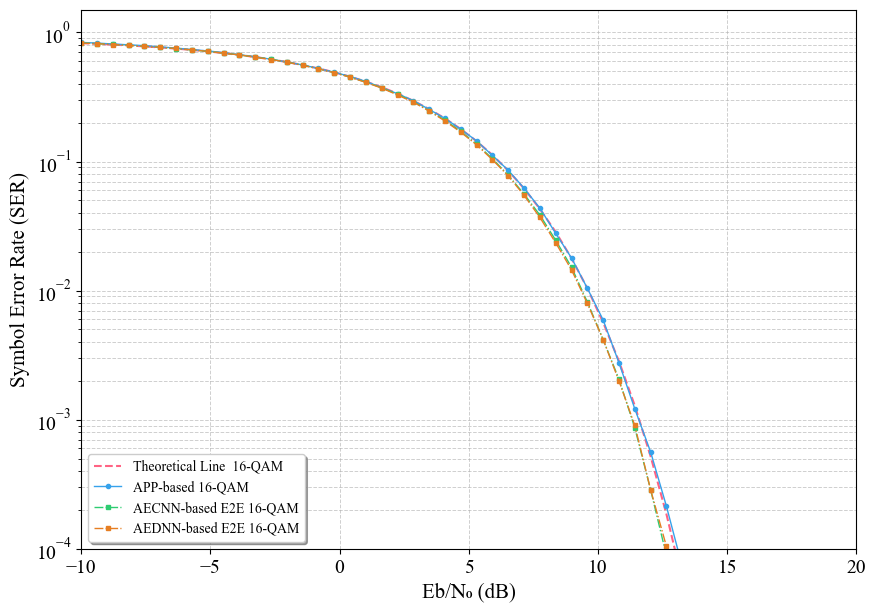

In [ ]:
mpl.rcParams['font.family'] = 'serif'  # or 'sans-serif', 'monospace', etc.
mpl.rcParams['font.serif'] = ['Times New Roman']  # or any available font on your system
mpl.rcParams['font.size'] = 14  # Increase this for larger text

eb_no_db_range = np.linspace(EBNO_MIN, EBNO_MAX, 50)
ser_theo_16 = Theoretical_Line(eb_no_db_range,16)


plt.figure(figsize=(10, 7))
plt.semilogy(eb_no_db_range, ser_theo_16, '--', color = new_red, label=f'Theoretical Line  16-QAM')
plt.semilogy(eb_no_db_range, SER['Baseline_16'],'o-', color = new_blue, markersize = 3,linewidth=1, label = f'APP-based 16-QAM')
plt.semilogy(eb_no_db_range, SER['AutoEncoder - CNN-16'], 's-.', color = new_green, markersize=3,linewidth=1, label = f'AECNN-based E2E 16-QAM')
plt.semilogy(eb_no_db_range, SER['AutoEncoder - DNN-16'], 's-.', color = new_orange, markersize=3,linewidth=1, label = f'AEDNN-based E2E 16-QAM')


plt.legend(loc='lower left', fontsize=10, frameon=True, shadow=True, fancybox=True)
plt.xlabel('Eb/N₀ (dB)',fontsize=15)
plt.ylabel('Symbol Error Rate (SER)',fontsize=15)

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
plt.ylim(1e-4, 1.5)
plt.xlim(-10,20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()